# Previsión de la inflación mexicana mediante redes neuronales

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Importar pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

Para este proyecto usamos como referencia el siguiente articulo: J. L. Chavez Hurtado and J. H. Cortes-Fregoso, "Forecasting Mexican inflation using neural networks," CONIELECOMP 2013, 23rd International Conference on Electronics, Communications and Computing, Cholula, Puebla, Mexico, 2013, pp. 32-35, doi: 10.1109/CONIELECOMP.2013.6525753.

En este trabajo  se utilizs un modelo de Redes Neuronales para pronosticar la inflación mexicana. En el se implementaron diferentes modelos de Redes Neuronales variando el número de capas ocultas (1 y 2) y el número de neuronas en la capa oculta (de 1 a 100). Los resultados del modelo de previsión se dividieron en 3 categorías: una fase de inflación volátil, en la que la diferencia media fue del 0,64% entre la inflación real y la inflación prevista; una fase de transición, en la que la diferencia media fue del 5,44%; y una fase de estabilidad, en la que la diferencia media fue del 0,28%. Al hacer una comparación entre los resultados del pronóstico del modelo y las predicciones del Banco de México, los resultados del modelo de Redes Neuronales son claramente más precisos al comportamiento de la inflación real, un punto crítico durante los periodos de crisis inflacionaria. 

En el trabajo de Chavez y Cortes, se implemento el modelo NN multicapa Feedforward utilizando la NN Toolbox de Matlab (Multilayer Feedforward NN model will be implemented using the NN Toolbox from Matlab.)

Nosotros utilizaremos Pytorch para definir igualmente un modelo NN multicapa, y exploraremos varias arquitecturas.

"In order to train the NN we used a database provided by the Bank of Mexico which contains monthly inflation, annual inflation and annual inflation expected according to inflation measured each month. January inflation is used as the input vector and annual inflation as the target vector. Expected inflation is used to compare NN results with the Bank of Mexico expectations" (Chávez-Hurtado,Cortés-Fregoso.2013)

De manera similar al árticulo, para entrenar la NN utilizamos una base de datos proporcionada por el Banco de México que contiene la inflación mensual, la inflación anual y la inflación anual esperada según la inflación medida cada mes. La inflación de enero se utiliza como vector de entrada y la inflación anual como vector objetivo. La inflación esperada se utiliza para comparar los resultados de la NN con las expectativas del Banco de México. (Chávez-Hurtado,Cortés-Fregoso.2013)

In [114]:
# Descargado de https://www.banxico.org.mx/SieInternet/consultarDirectorioInternetAction.do?accion=consultarCuadro&idCuadro=CP151&locale=en

path = 'data/Consulta_03.csv'
df = pd.read_csv(path, sep=',', encoding='utf-8')
columnas = df.columns  
df.head()

,Fecha,Inflacion Indice de precios al consumidor (INPC) mensual,Inflacion Indice de precios al consumidor (INPC) acumulada en el anio,Inflacion Indice de precios al consumidor (INPC) anual,Inflacion subyacente mensual,Inflacion subyacente acumulada en el año,Inflacion subyacente anual,Inflacion no subyacente mensual,Inflacion no subyacente acumulada en el año,Inflacion no subyacente anual
0,01/01/1971,16.470588,-78.891258,5.117271,N/E,N/E,N/E,N/E,N/E,N/E
1,01/02/1971,-51.764706,-70.149254,14.712154,N/E,N/E,N/E,N/E,N/E,N/E
2,01/03/1971,-55.294118,-61.833689,16.631130,N/E,N/E,N/E,N/E,N/E,N/E
3,01/04/1971,-40.000000,-50.746269,25.159915,N/E,N/E,N/E,N/E,N/E,N/E
4,01/05/1971,-75.294118,-46.055437,25.159915,N/E,N/E,N/E,N/E,N/E,N/E


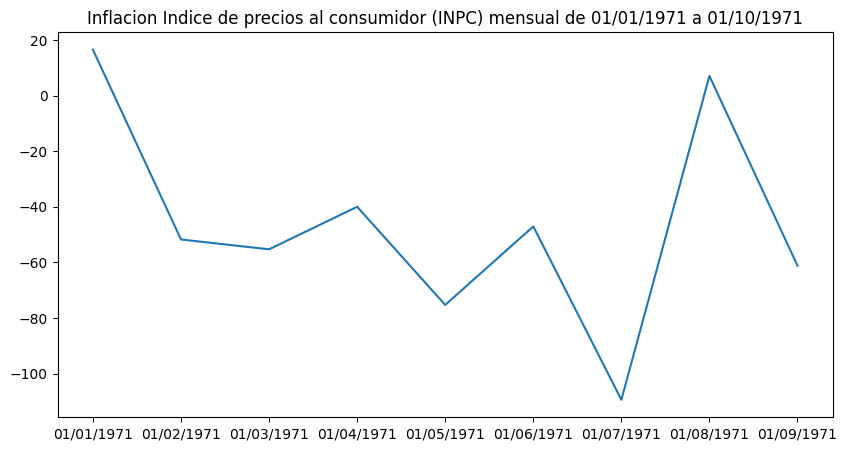

In [115]:
# Print Inflacion indice de precios al consumidor
num = 9
plt.figure(figsize=(10,5))
fecha_inicial = df['Fecha'][0]
fecha_final = df['Fecha'][num]

fecha = df['Fecha'][0:num]
inflacion = df[columnas[1]][0:num]
plt.plot(fecha, inflacion,)
plt.title(str(columnas[1])+" de "+str(fecha_inicial)+" a "+str(fecha_final))
plt.show()


In [116]:
INPC_mensual = df[columnas[1]]
INPC_acumulada = df[columnas[2]]
INPC_anual = df[columnas[3]]
Inflacion_subyacente_mensual = df[columnas[4]]
Inflacion_subyacente_acumulada = df[columnas[5]]
Inflacion_subyacente_anual = df[columnas[6]]
Inflacion_no_subyacente_mensual = df[columnas[7]]
Inflacion_no_subyacente_acumulada = df[columnas[8]]
Inflacion_no_subyacente_anual = df[columnas[9]]
fecha = df['Fecha']

In [117]:
eneros = list()
for f in fecha:
    anio = f.split('/')[2]
    anio = int(anio)
    mes = f.split('/')[1]
    mes = int(mes)
    # Seleccionar datos a partir de 1984
    if anio >= 1984:
        # Seleccionamos los eneros
        if mes == 1:
            eneros.append(f)

In [118]:
# Seleccionar los datos de enero
df_eneros = df[df['Fecha'].isin(eneros)]
df_eneros = df_eneros.reset_index(drop=True)
df_eneros.head()

,Fecha,Inflacion Indice de precios al consumidor (INPC) mensual,Inflacion Indice de precios al consumidor (INPC) acumulada en el anio,Inflacion Indice de precios al consumidor (INPC) anual,Inflacion subyacente mensual,Inflacion subyacente acumulada en el año,Inflacion subyacente anual,Inflacion no subyacente mensual,Inflacion no subyacente acumulada en el año,Inflacion no subyacente anual
0,01/01/1984,48.364486,-92.139143,-9.135925,22.99,-93.82,-12.36,144.28,-84.46,3.77
1,01/01/1985,74.588235,-87.457742,2.687627,24.41,-91.17,-0.27,245.39,-74.21,12.82
2,01/01/1986,29.809104,-86.133333,3.403922,92.15,-86.02,8.32,-36.29,-86.58,-10.93
3,01/01/1987,2.531646,-92.340426,-1.333333,7.65,-92.31,-0.49,-13.23,-92.50,-4.21
4,01/01/1988,4.671632,-90.287114,11.095056,6.02,-91.64,7.40,-0.99,-85.89,23.43


La forma en que los datos están estruturados es que cada entrada corresponde a un mes por cada entrada. Debido al gran número de datos faltantes tomaremos datos a partir de 01/01/1984

Haremos una ligera variación a lo que hace el articulo y tomaremos desde 1984 al 2021. Y compararemos las predicciones del 2021 al 2023.

Tomaremos los datos de enero como Inflacion Indice de precios al consumidor (INPC) mensual, Inflacion Indice de precios al consumidor (INPC) acumulada en el anio, Inflacion subyacente mensual,Inflacion subyacente acumulada en el año, Inflacion subyacente anual,Inflacion no subyacente mensual,Inflacion no subyacente acumulada en el año, Inflacion no subyacente anual como features y la Inflacion Indice de precios al consumidor (INPC) anual como target.


In [119]:
# Nuestro objetivo es predecir la inflación anual
# Seleccionamos la inflación anual
inflacion_anual = df_eneros[columnas[3]]
inflacion_anual = inflacion_anual[0:36]
fecha = df_eneros['Fecha']
fecha = fecha[0:36]
plt.figure(figsize=(10,5))
plt.plot(fecha, inflacion_anual)
plt.title("Inflación anual")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Normalizar los datos
inflacion_anual = np.array(inflacion_anual)
# Definir y con:
#INPC_anual = df[columnas[3]]
y = df_eneros[columnas[3]]
# Definir X con:
X = np.array(df_eneros[[columnas[1], columnas[2], columnas[4], columnas[5], columnas[6], columnas[7], columnas[8], columnas[9]]])
# Normalizar los datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Convertir a tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
print(X.shape, y.shape)

"So database will contain annual inflation values from 1970 to 1993
and the selected NN model will be used to forecast inflation
from 1994 to 2010. From the database, 70% of data will be
used to train the NN and the remain 30% will be used to
measure its performance according to the mean square error
(MSE). The NN model with the least MSE will be selected to
forecast inflation. The activation function used in the hidden
layers was the hyperbolic tangent and the rest of the
specifications were set to default Matlab values."

In [ ]:
# Definir y utilizar conjunto de validación
# El 70% de los datos serán para entrenamiento, el 15% para validación y el 15% para prueba
n = len(X)
n_train = int(0.7*n)
n_val = int(0.15*n)
indices = np.random.permutation(n)

train_indices, val_indices, test_indices = indices[:n_train], indices[n_train:n_train+n_val], indices[n_train+n_val:]
X_train, X_val, X_test = X[train_indices], X[val_indices], X[test_indices]
y_train, y_val, y_test = y[train_indices], y[val_indices], y[test_indices]
print(X_train.shape, X_val.shape, X_test.shape)


The model with the best MSE was a NN model with 1 hidden layer and 49 hidden neurons. This NN model was selected to forecast annual inflation

In [ ]:
#Crear el modelo
# The model with the best MSE was a NN model with 1 hidden layer and 49 hidden neurons. This NN model was selected to forecast annual inflation
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 49)
        self.fc2 = nn.Linear(49, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# Crear el modelo
model = Net()
# Definir la función de pérdida
loss_function = nn.MSELoss()
# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Entrenar el modelo usando el conjunto de entrenamiento y validación
n_epochs = 100000
train_losses = []
val_losses = []

for epoch in range(n_epochs):

    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_function(y_pred.view(-1), y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # Evaluar el modelo con el conjunto de validación
    model.eval()
    y_val_pred = model(X_val)
    loss_val = loss_function(y_val_pred.view(-1), y_val)
    val_losses.append(loss_val.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Train Loss {loss.item()}, Validation Loss {loss_val.item()}')

In [ ]:
# Graficar la función de pérdida
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss function')
plt.show()

In [ ]:
# Predecir la inflación
# Normalizar los datos
X = scaler.transform(X)
# Convertir a tensor
X = torch.tensor(X, dtype=torch.float32)
# Predecir
y_pred = model(X)
y_pred = y_pred.view(-1)
# Calcular el error
error = loss_function(y_pred, y)
print(f'Error: {error.item()}')
# Graficar la inflación real y la inflación predicha
plt.figure(figsize=(10,5))
plt.plot(y_pred.detach().numpy(), label='Predicción')
plt.plot(y.detach().numpy(), label='Real')
plt.legend()
plt.title('Inflación real vs Inflación predicha')
plt.show()

In [ ]:
# Evaluar el modelo
# Calcular el error cuadrático medio
from sklearn.metrics import mean_squared_error
y_pred = y_pred.detach().numpy()
y = y.detach().numpy()

mse = mean_squared_error(y, y_pred)
print(f'MSE: {mse}')

# Calcular el error absoluto medio
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y, y_pred)
print(f'MAE: {mae}')

# Matriz de correlación
correlation_matrix = np.corrcoef(y, y_pred)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(f'R^2: {r_squared}')

# Matriz de confusión
from sklearn.metrics import confusion_matrix
y_pred = np.where(y_pred > 0, 1, 0)
y = np.where(y > 0, 1, 0)
cm = confusion_matrix(y, y_pred)
print(cm)
